<a href="https://colab.research.google.com/github/Dain777666/ESAA_25-1/blob/main/ESAA_WEEK3_MON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

** < 과제: 새로운 전처리/시각화를 1가지 이상 적용 > **

> 새로운 전처리: 제품별 장바구니 추가 순서 평균

아이디어: 각 제품이 장바구니에 추가되는 평균 순서를 계산하면, 사용자가 얼마나 일찍 담는 제품인지를 알 수 있음. 평균적으로 먼저 추가되는 제품은 필수품일 가능성이 높고, 나중에 추가되는 제품은 충동 구매 제품일 가능성이 있음.

> 새로운 시각화: 장바구니 추가 순서 분포

avg_add_to_cart_order가 작은 제품과 큰 제품을 시각화하여, 어떤 제품이 필수품 vs 비필수품인지 확인함. 히스토그램 플롯을 사용하여 장바구니 추가 순서의 전반적인 분포를 탐색함.

In [19]:
#Let's import the necessary modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Seaborn의 기본 색상 팔레트를 반환하는 함수
color = sns.color_palette()

#그래프를 별도 창이 아니라 노트북 셀 안에서 바로 볼 수 있도록 설정하는 기능
%matplotlib inline

#Pandas의 체인 인덱싱(Chained Assignment) 경고를 끄는 설정
#오류가 발생할 수 있기 때문에 권장되지 않음
pd.options.mode.chained_assignment = None #default = 'warn'

In [20]:
#구글 드라이브를 코랩에 연결하기
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
order_products_train_df = pd.read_csv("/content/drive/MyDrive/order_products__train.csv")
order_products_prior_df = pd.read_csv("/content/drive/MyDrive/order_products__prior.csv")
orders_df = pd.read_csv("/content/drive/MyDrive/orders.csv")
products_df = pd.read_csv("/content/drive/MyDrive/products.csv")
aisles_df = pd.read_csv("/content/drive/MyDrive/aisles.csv")
departments_df = pd.read_csv("/content/drive/MyDrive/departments.csv")

In [22]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [23]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [24]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


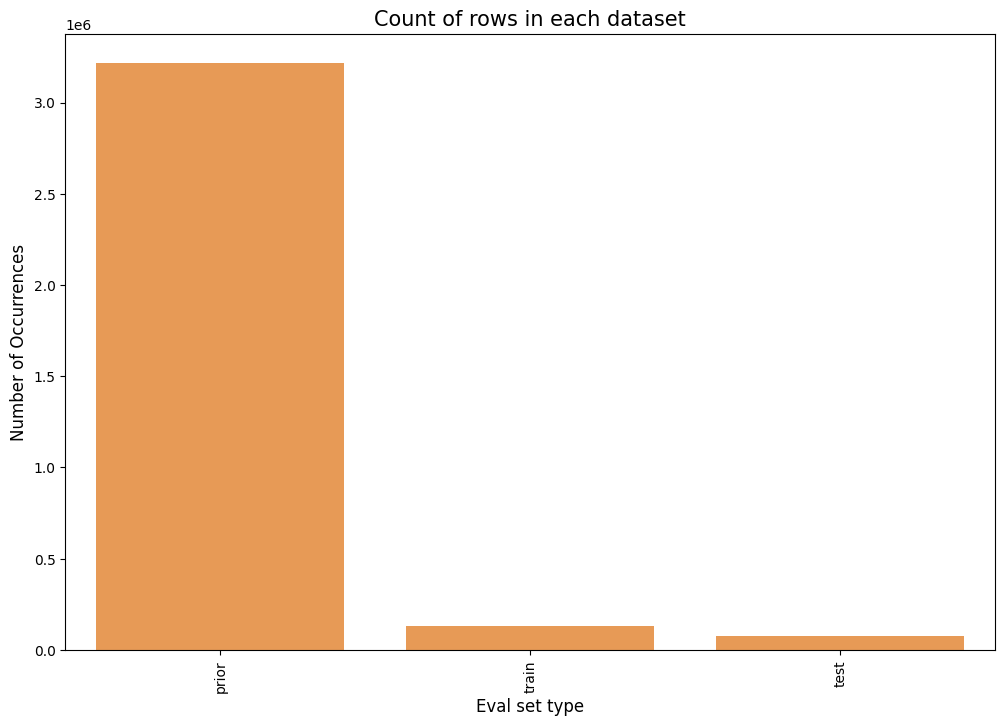

In [25]:
cnt_srs = orders_df.eval_set.value_counts()
print(cnt_srs)

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[1]) #alpha는 막대의 투명도를 조절하는 역할
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Eval set type', fontsize=12)
plt.title('Count of rows in each dataset', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

In [26]:
#각 데이터셋마다 user_id의 unique값 개수 세기
def get_unique_count(x):
  return len(np.unique(x))

#aggregate()를 이용하여 만든 함수 적용하기
cnt_srs = orders_df.groupby("eval_set")["user_id"].aggregate(get_unique_count)
cnt_srs

,user_id
eval_set,
prior,206209
test,75000
train,131209


✅ So, there are 206,209 customers in total. Out of which, the last purchase of 131,209 customers are given as train set and we need to predict for the rest 75,000 customers.

-----------------------

▶ Now, let us validate the claim that 4 to 100 orders of a customer are given.

<ipython-input-27-b68221b8b99f>:4: FutureWarning: The provided callable <function max at 0x7fbc215c49a0> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()


order_number
4     23986
5     19590
6     16165
7     13850
8     11700
      ...  
94       57
91       56
97       54
98       50
99       47
Name: count, Length: 97, dtype: int64


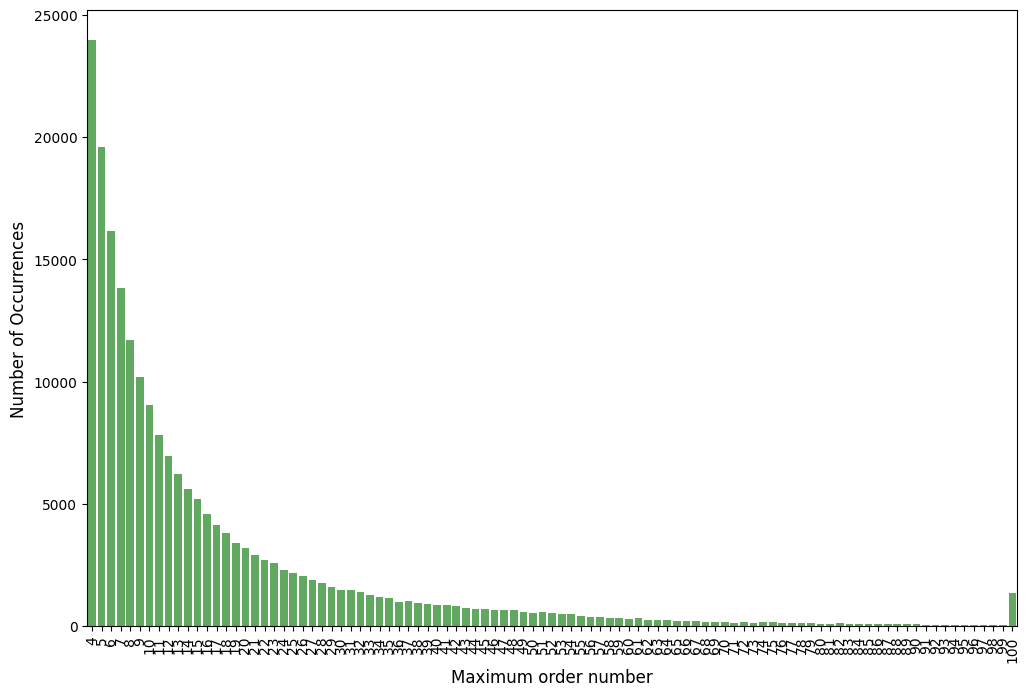

In [27]:
#orders_df 데이터프레임을 user_id별로 그룹화
#각 users_id가 가진 order_number 값 중 최대값(np.max)을 가져옴
#reset_index()를 사용하여 새로운 데이터프레임 형태로 변환
cnt_srs = orders_df.groupby("user_id")["order_number"].aggregate(np.max).reset_index()

#cnt_srs에서 order_number 칼럼을 가져와서 각 주문 횟수별로 몇 명의 사용자가 있는 지 세기
cnt_srs = cnt_srs.order_number.value_counts()
print(cnt_srs)

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

✅ So, there are no orders less than 4 and is max capped at 100 as given in the data page.

------

▶ Now, let us see how the ordering habit changes with day of week. (요일에 따라 주문 습관이 어떻게 바뀌는 지 확인)


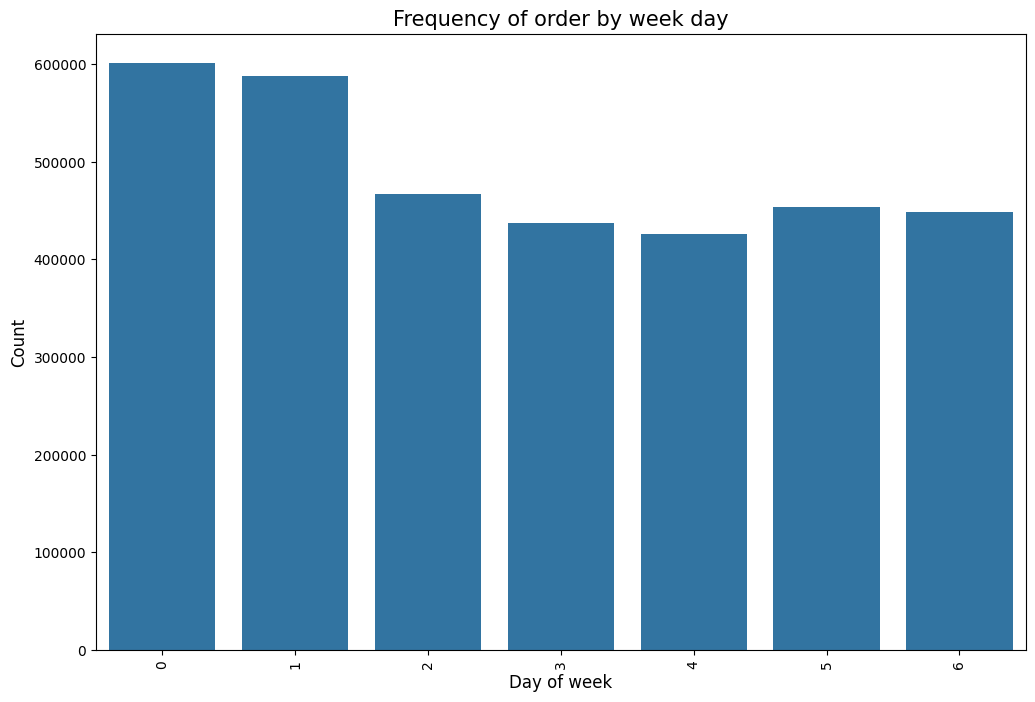

In [28]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

✅ Seems like 0 and 1 is Saturday and Sunday when the orders are high and low during Wednesday.

----------

▶ Now, we shall see how the distribution is with respect to time of the day.

In [29]:
orders_df['order_hour_of_day'].unique()

array([ 8,  7, 12, 15,  9, 14, 16, 11, 10, 19, 18, 17, 13, 20,  0, 21, 22,
        5, 23,  4,  6,  1,  2,  3])

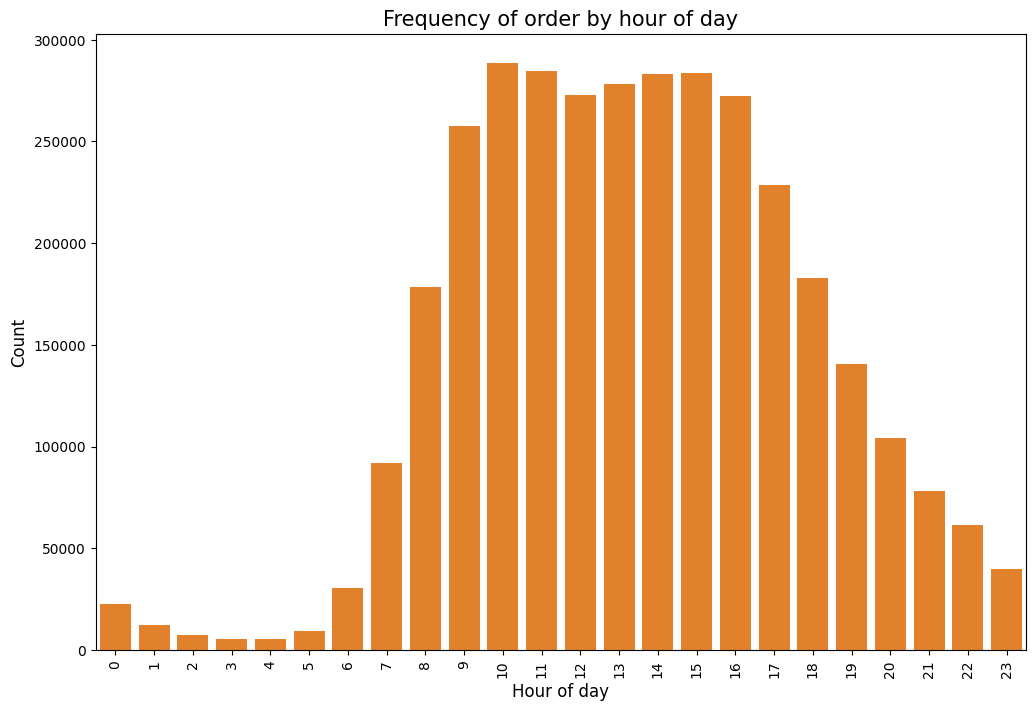

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

✅So, the majority of orders are made during day time.

----------

▶ Now, let us combine the day of week and hour of day to see the distribution.

order_hour_of_day    0     1     2    3    4     5     6      7      8   \
order_dow                                                                 
0                  3936  2398  1409  963  813  1168  3329  12410  28108   
1                  3674  1830  1105  748  809  1607  5370  16571  34116   
2                  3059  1572   943  719  744  1399  4758  13245  24635   
3                  2952  1495   953  654  719  1355  4562  12396  22553   
4                  2642  1512   899  686  730  1330  4401  12493  21814   
5                  3189  1672  1016  841  910  1574  4866  13434  24015   
6                  3306  1919  1214  863  802  1136  3243  11319  22960   

order_hour_of_day     9   ...     14     15     16     17     18     19  \
order_dow                 ...                                             
0                  40798  ...  54552  53954  49463  39753  29572  22654   
1                  51908  ...  46764  46403  44761  36792  28977  22145   
2                  36314

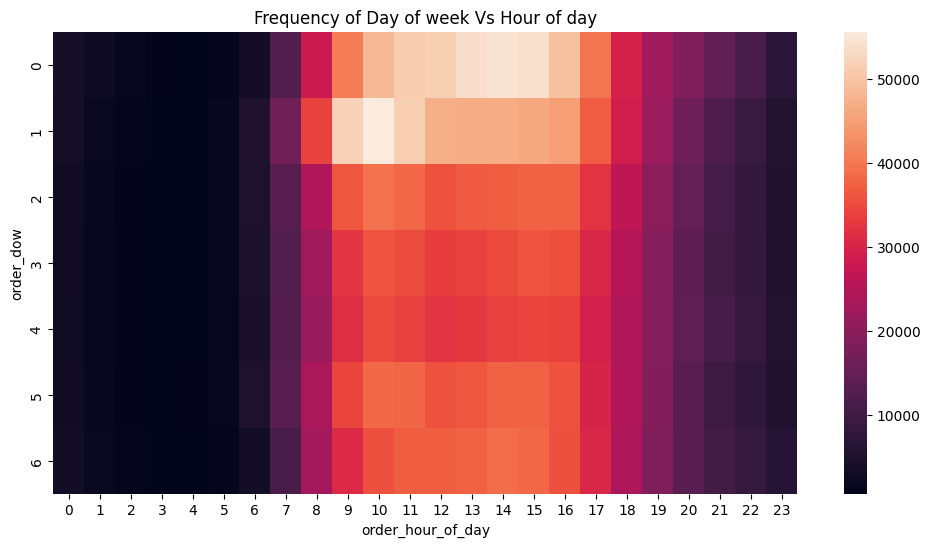

In [31]:
grouped_df = orders_df.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')
#df.pivot(index='',columns='',values='') 각각 행 인덱스, 새로운 열로 변환할 값, 값으로 들어갈 데이터
#판다스에서 데이터를 재구성하는 데 사용하는 메서드
print(grouped_df)

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

✅ Seems Saturday evenings and Sunday mornings are the prime time for orders.

-------

▶ Now, let us check the time interval between the orders.

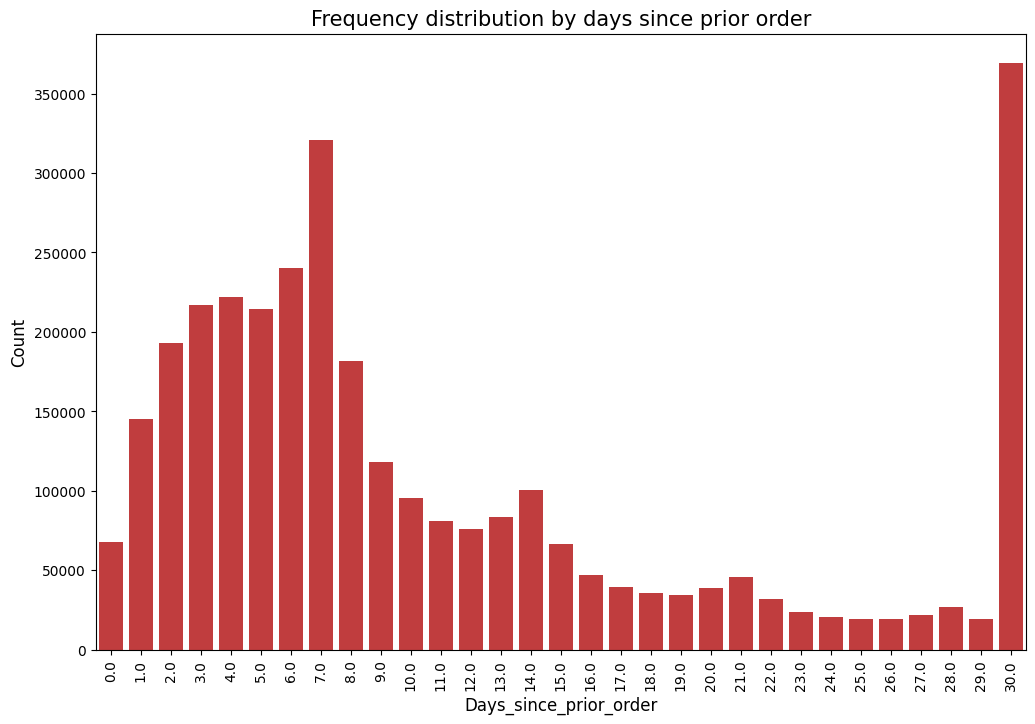

In [32]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days_since_prior_order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

✅ Looks like customers order once in every week(check the peak at 7 days) or once in a month(peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

---------

▶ Since our objective is to figure out the re-orders, let us check out the re-order percentage in prior set and train set.

In [33]:
## percentage of re-orders in prior set ##

#재주문건수 총합 / 전체주문건수(= 행의 개수)
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

np.float64(0.5896974667922161)

In [34]:
## percentage of re-orders in train set ##

order_products_train_df.reordered.sum() / order_products_train_df.shape[0]

np.float64(0.5985944127509629)

✅ On an average, about 59% of the products in an order are re-ordered products.

------------

▶ Now that we have seen 59% of the products are re-ordered, there will also be situations when none of the products are re-ordered. Let us check that now.

In [35]:
grouped_df = order_products_prior_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1 #재주문건수가 2개 이상이면 1로 변경, 1은 그대로 유지
#.loc[...] = 1: 선택된 행들의 값을 1로 변경
grouped_df.reordered.value_counts() / grouped_df.shape[0] #재주문이 1개 이상인 경우와 0개인 경우의 비율 계산

<ipython-input-35-e2eb9a7f5fe9>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1 #재주문건수가 2개 이상이면 1로 변경, 1은 그대로 유지


,count
reordered,
1,0.879151
0,0.120849


In [36]:
grouped_df = order_products_train_df.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

<ipython-input-36-80c704cc6039>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  grouped_df["reordered"].loc[grouped_df["reordered"]>1] = 1


,count
reordered,
1,0.93444
0,0.06556


✅ About 12% of the orders in prior set has no re-ordered items while in the train set is 6.5%.

------

▶ Now, let us see the number of products bought in each order.

In [37]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
print(grouped_df)

        order_id  add_to_cart_order
0              1                  8
1             36                  8
2             38                  9
3             96                  7
4             98                 49
...          ...                ...
131204   3421049                  6
131205   3421056                  5
131206   3421058                  8
131207   3421063                  4
131208   3421070                  3

[131209 rows x 2 columns]


In [38]:
cnt_srs = grouped_df.add_to_cart_order.value_counts()


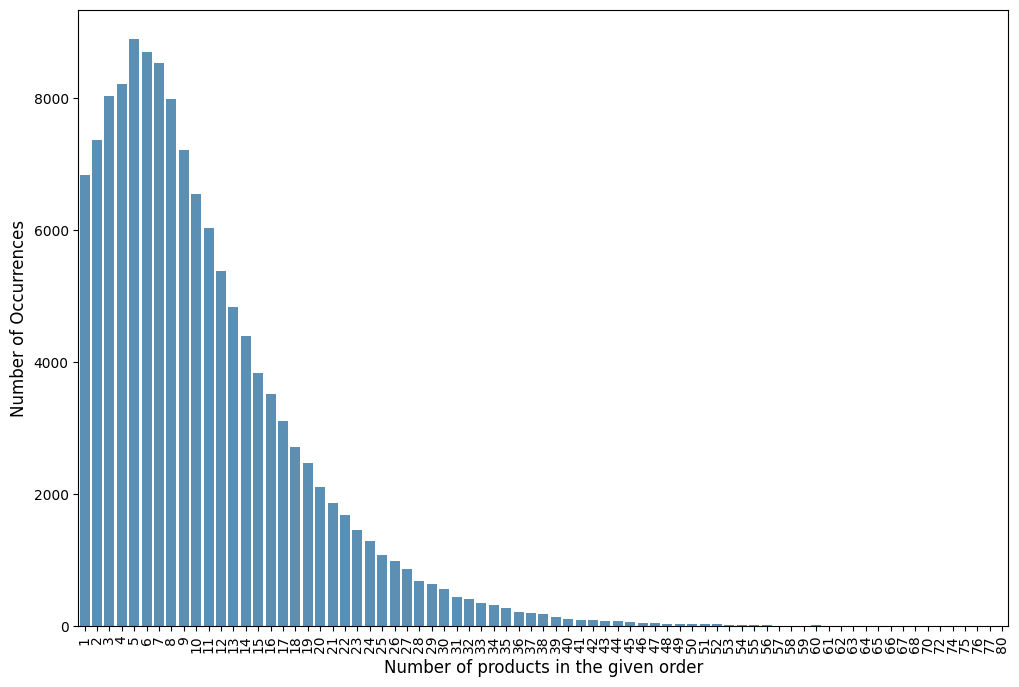

In [39]:
plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

✅ A right tailed distribution with the maximum value at 5.

------

▶ Before we explore the product details, let us look at the other three files as well.

In [40]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [41]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [42]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


▶ Now let us merge these product details with the order_prior details.

In [43]:
#order_products_prior 파일에 새로운 파일 merge하기
#pd.merge(df1, df2, on='공통칼럼', how='오른쪽/왼쯕')
order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')

order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry


In [44]:
cnt_srs = order_products_prior_df['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


✅ Most of them are organic products. Also majority of them are fruits.

---

▶ Now let us look at the important aisles.

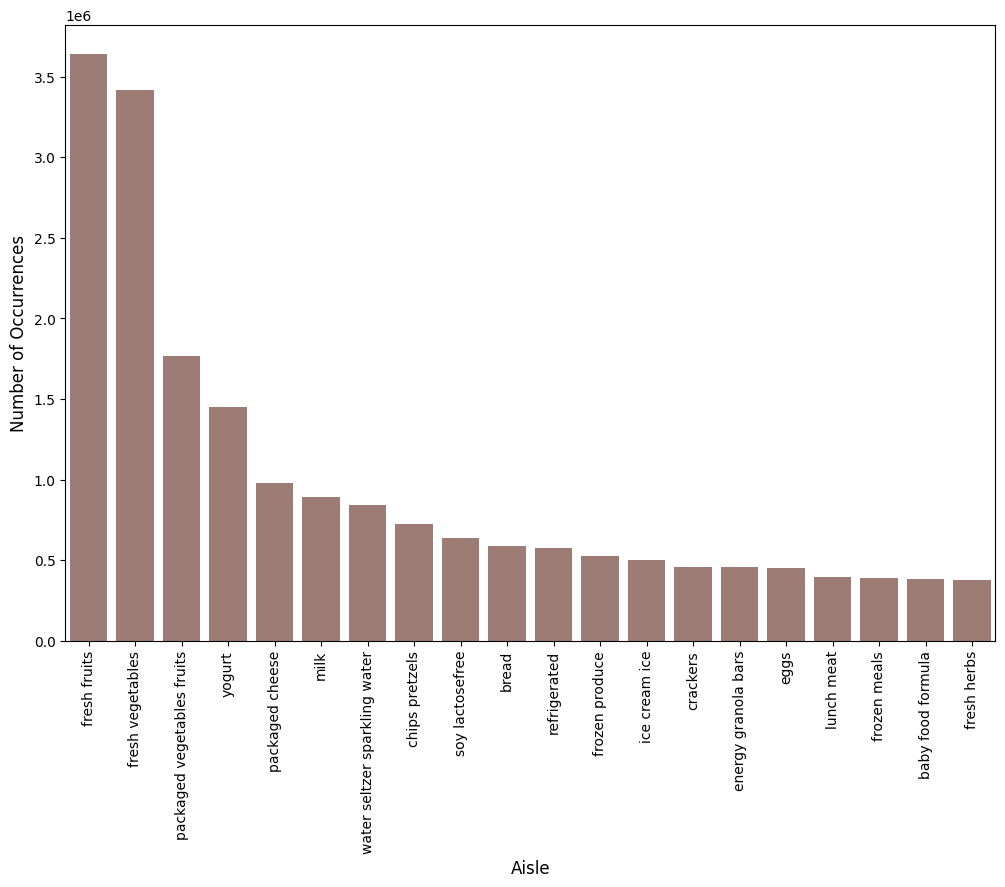

In [45]:
cnt_srs = order_products_prior_df['aisle'].value_counts().head(20)

plt.figure(figsize=(12,8))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

✅ The top two aisles are fresh fruits and fresh vegetables.

--------

▶ Let us now check the department wise distribution.

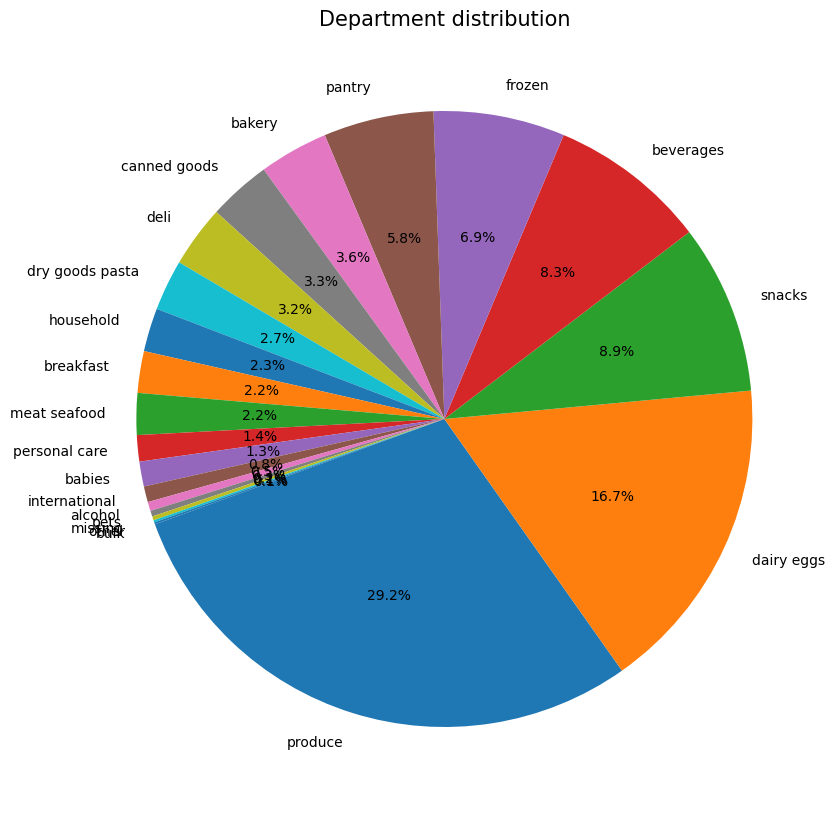

In [46]:
plt.figure(figsize=(10,10))
temp_series = order_products_prior_df['department'].value_counts()
labels = (np.array(temp_series.index)) #인덱스를 레이블로 설정
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200) #소수점 밑 첫째자리까지만 표시, 200도에서 부터 그래프 표시 시작
plt.title("Department distribution", fontsize=15)
plt.show()

✅ Produce is the largest department.

------

▶ Now let us check the reordered percentage of each department.

 Department wise reorder ratio:

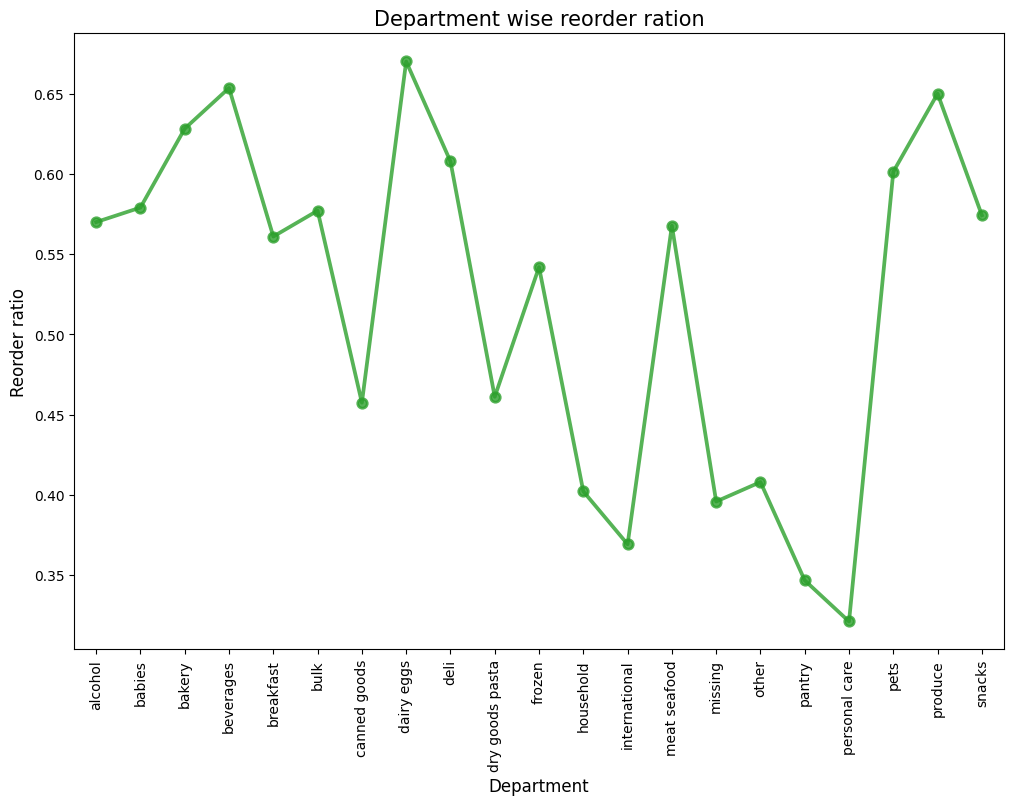

In [47]:
grouped_df = order_products_prior_df.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['department'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ration", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

✅ Personal care has lowest reorder ratio and dairy eggs have highest reorder ratio.

------

▶ Aisle - Reorder ratio:

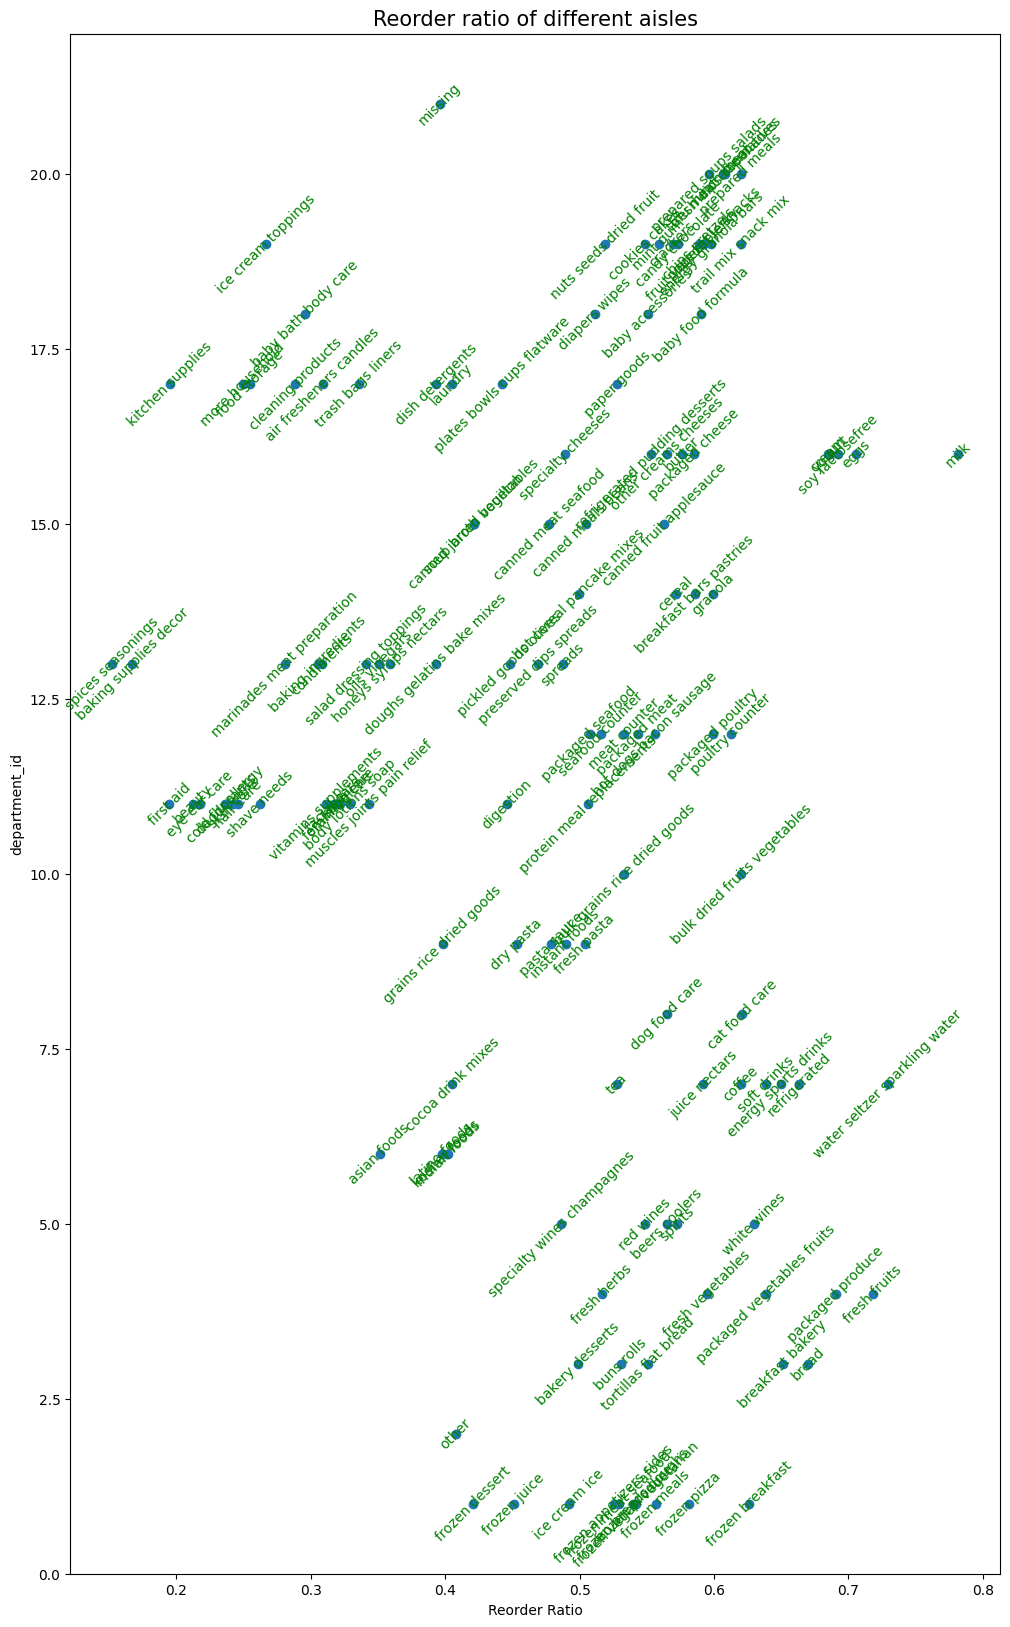

In [48]:
grouped_df = order_products_prior_df.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
  ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]),
              rotation=45, ha='center', va='center', color='green')
plt.ylabel('department_id')
plt.xlabel('Reorder Ratio')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

▶ Let us now explore the relationship between how order of adding the product to the cart affects the reorder ratio.

<ipython-input-49-c75c118bc44c>:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70


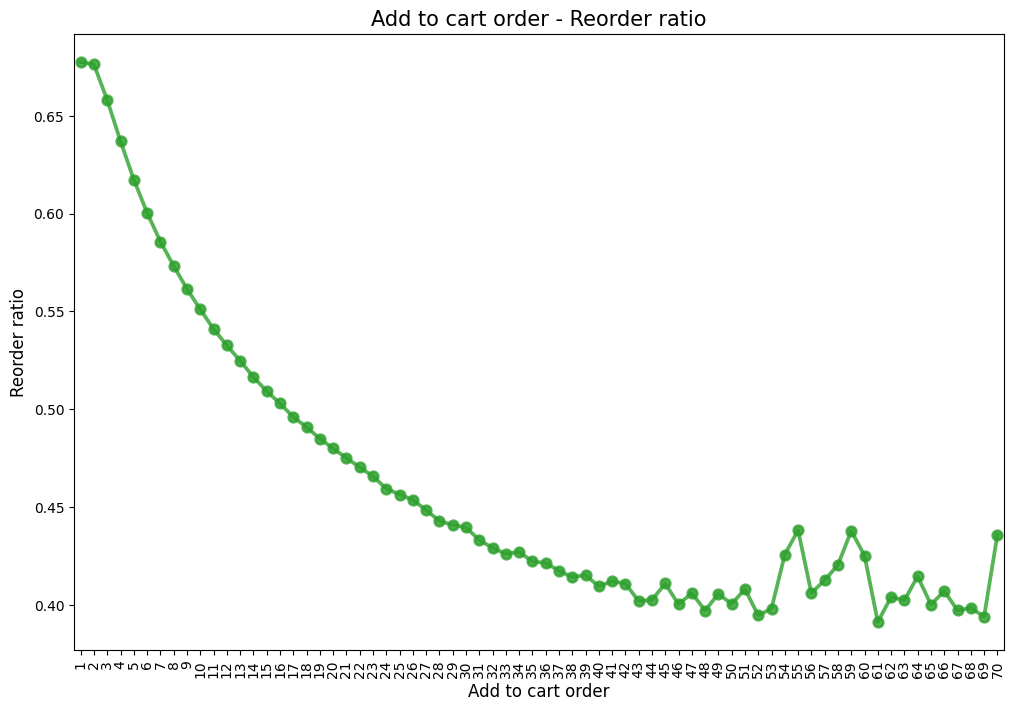

In [49]:
order_products_prior_df["add_to_cart_order_mod"] = order_products_prior_df["add_to_cart_order"].copy()
order_products_prior_df["add_to_cart_order_mod"].loc[order_products_prior_df["add_to_cart_order_mod"]>70] = 70
grouped_df = order_products_prior_df.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(x=grouped_df['add_to_cart_order_mod'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

✅Looks like the products that are added to the cart initially are more likelt to be reordered again compared to the ones added later. This makes sense to me as well since we tend to first order all the products we used to buy frequenlty and then look out for the new prouducts available.

---

▶ Reorder ratio by Time based variables:

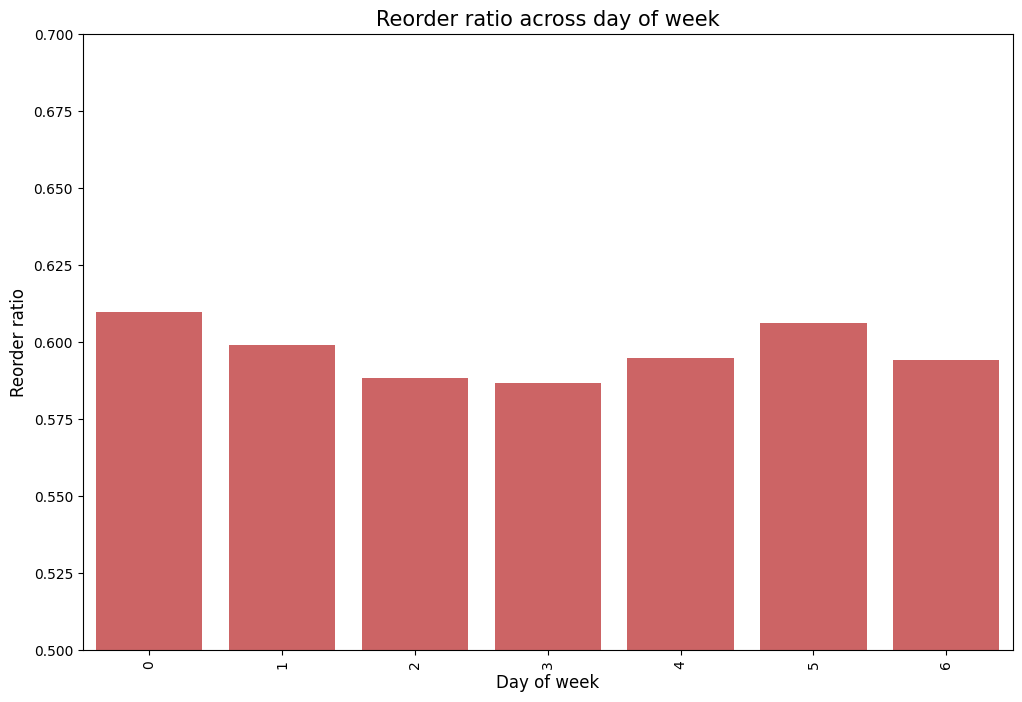

In [50]:
order_products_train_df = pd.merge(order_products_train_df, orders_df, on='order_id', how='left')
grouped_df = order_products_train_df.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_dow'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

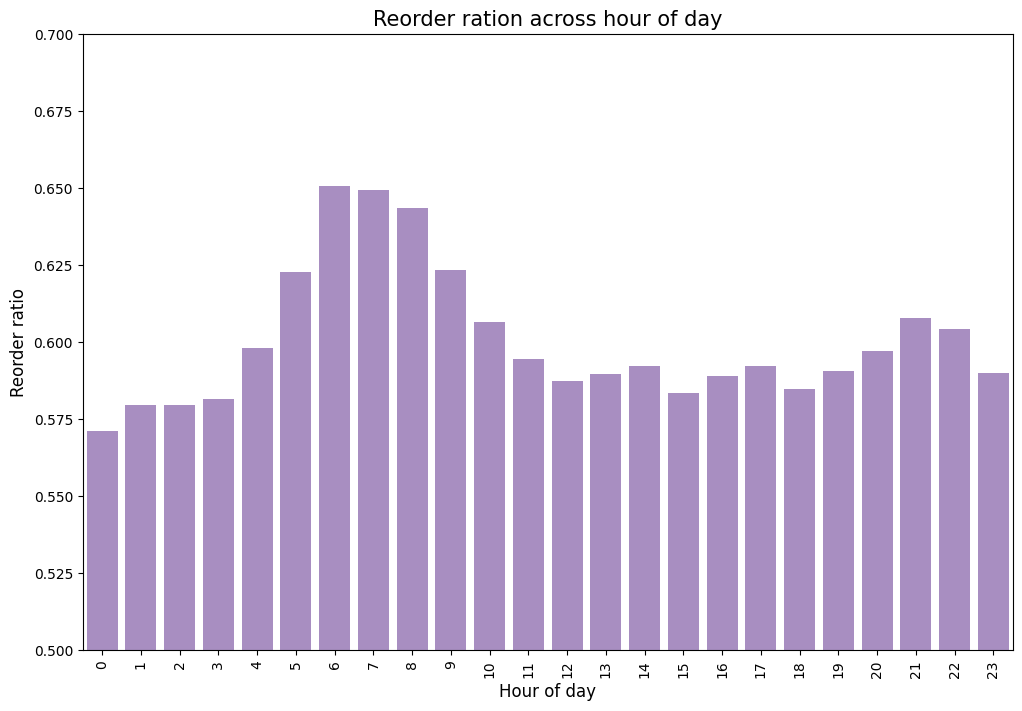

In [51]:
grouped_df = order_products_train_df.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.barplot(x=grouped_df['order_hour_of_day'].values, y=grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ration across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

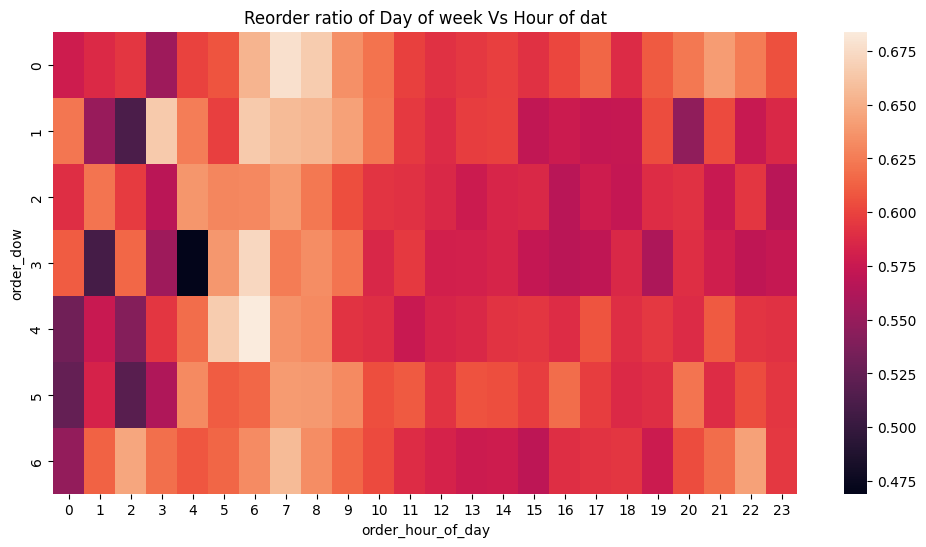

In [52]:
grouped_df = order_products_train_df.groupby(["order_dow", "order_hour_of_day"])["reordered"].aggregate("mean").reset_index()
grouped_df = grouped_df.pivot(index='order_dow', columns='order_hour_of_day', values='reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of dat")
plt.show()

✅ Looks like reorder ratios are quite high during the early mornings compared to later half of the day.

In [55]:
###새로운 전처리###

#제품별 평균 add_to_cart_order 계산
product_cart_order = order_products_prior_df.groupby('product_id')['add_to_cart_order'].mean().reset_index()
product_cart_order.columns = ['product_id', 'avg_add_to_cart_order']

#제품 정보와 병합
product_cart_order = product_cart_order.merge(products_df[['product_id', 'product_name']], on='product_id')

#가장 먼저 장바구니에 추가되는 제품 TOP 10
top_early_products = product_cart_order.nsmallest(10, 'avg_add_to_cart_order')

#가장 나중에 장바구니에 추가되는 제품 TOP 10
top_late_products = product_cart_order.nlargest(10, 'avg_add_to_cart_order')

#결과 출력
print("가장 먼저 장바구니에 추가되는 제품 (필수품) TOP 10")
print(top_early_products[['product_name', 'avg_add_to_cart_order']])

print("가장 나중에 장바구니에 추가되는 제품 (비필수품) TOP 10")
print(top_late_products[['product_name', 'avg_add_to_cart_order']])

가장 먼저 장바구니에 추가되는 제품 (필수품) TOP 10
                                            product_name  \
2768                             Pappardelle Nests Pasta   
2795                                      American Blend   
3830                                          Quart Bags   
11250  Drink Distinct All Natural Soda Pineapple Coco...   
12837                                     King Crab Legs   
25436                                      Spicy Falafel   
25883                      Super Nutrition Vanilla Shake   
27857                                       Cooking Fuel   
30337                         Seltzer Blueberry Lemonade   
33434                    Rosa Mosqueta Rose Hip Seed Oil   

       avg_add_to_cart_order  
2768                     1.0  
2795                     1.0  
3830                     1.0  
11250                    1.0  
12837                    1.0  
25436                    1.0  
25883                    1.0  
27857                    1.0  
30337                    1.

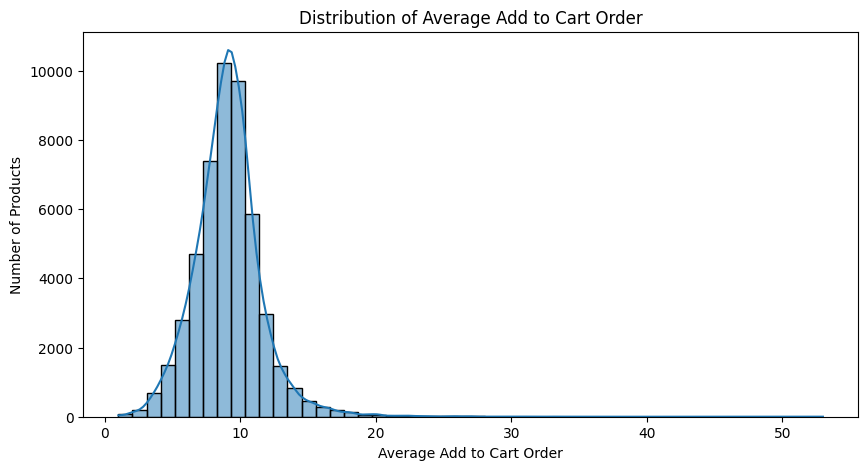

In [56]:
### 새로운 시각화 ###

plt.figure(figsize=(10,5))
sns.histplot(product_cart_order['avg_add_to_cart_order'], bins=50, kde=True)
plt.xlabel('Average Add to Cart Order')
plt.ylabel('Number of Products')
plt.title('Distribution of Average Add to Cart Order')
plt.show()